# Simple step-by-step guide to using `brewmaster`.

In [1]:
import os
import glob
import numpy as np
import aplpy
from astropy.io import fits
from astropy.table import Table

from brewmaster.generate_dummy_data import generate_tables
from brewmaster.quotient import Calibrate
from brewmaster.merge import Merge
from brewmaster.grid import Grid

import matplotlib.pyplot as plt
%matplotlib inline

/usr/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


## Using data

generate_tables creates some dummy data for us, to demonstrate usage of `brewmaster`. It will create HDF5 files for us to use. In a real-world scenario, another `brewmaster` function is used to convert MIRIAD data to HDF5 files, which would then be ready to use in all the following steps of this notebook.

In [2]:
generate_tables(seed=1000, rows=5, columns=10, x_extent=0.1, y_extent=0.25)
print(sorted(glob.glob("generated.ant?.hdf5")))

['generated.ant1.hdf5', 'generated.ant2.hdf5', 'generated.ant3.hdf5', 'generated.ant4.hdf5', 'generated.ant5.hdf5', 'generated.ant6.hdf5']


/usr/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Calibrate
The first main function of brewmaster is `Calibrate`. The options within `Calibrate` are listed below. In addition to using the reference data to form quotient spectra, `Calibrate` flags RFI, calculates system temperatues , and smoothes reference data before quotienting. The result is written to the same HDF5 files generated above, but in a separate 'path', such that the same file contains both the raw and calibrated data.

In [3]:
# Repeat the following procedure for each antenna's data.
for f in glob.glob("generated.ant?.hdf5"):
    # Create an instance of the Calibrate class...
    t = Calibrate(f,                         # The HDF5 file to work on.
                  extended=False,            # Extended emission?
                  edge_ignore=50,            # Chop off this many channels from the edges.
                  birdies=False,             # Let brewmaster determine where the birdie channels are (multiples of 128 for ATCA).
                  rename_references=True,    # Rename all reference spectra.
                  reference="ref",           # The name for the spectra to be renamed to.
                  path="raw")                # 'path' refers to a table inside the HDF5 file.
    # ... and apply the following options, before writing the result.
    t.prune(prune_radius=30)                 # Remove sources.
    t.flag_birdies()
    t.flag_rfi()                             # Remove extremely "bright" channel spikes.
    t.flag_weak_rfi()                        # Remove subtle channel spikes by analysing the average of all spectra.
    t.calibrate()                            # Calculate Tsys values and correct elevation-gain dependence.
    t.average_references(smoothing=True,     # Average reference data together for better quotients.
                         smooth_window=None) # Let brewmaster determine an appropriate number of channels to use when smoothing.
    t.quotient()
    t.write(path="quotiented")

To demonstrate what we've done, the following shows a spectrum before and after.

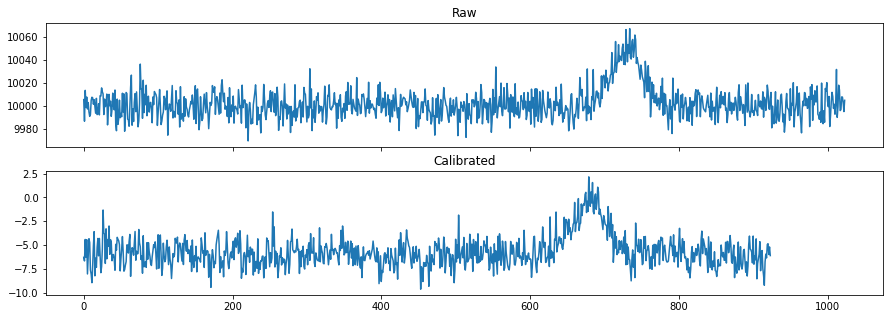

In [4]:
# Load up the data.
raw_table = Table.read("generated.ant1.hdf5", path="raw")
calibrated_table = Table.read("generated.ant1.hdf5", path="quotiented")
_, ax = plt.subplots(2, figsize=(15, 5), sharex=True)
# Plot a spectrum with a signal in it.
ax[0].set_title("Raw")
ax[0].plot(raw_table["xx"][33])
ax[1].set_title("Calibrated")
ax[1].plot(calibrated_table["xx"][32])

## Merge

The next function of brewmaster is `Merge`. This function reads the calibrated data from multiple HDF5 files, scanning for data collected at the same location. Using all available data, the spectra are averaged, then line-finding is performed before subtracting any bandpass ripples. The result of this function is a single, new HDF5 file containing one spectrum for every unique pointing.

By including all of the data simultaneously (as opposed to individually), any real signals in the data are more significant, and therefore easier to preserve before subtracting bandpass ripples.

In [5]:
# scales is a list of spectral-line widths that we're searching for (in units of channel width). Here, we allow line detection anywhere from 4 to 100 channels.
scales = list(range(4, 20, 2)) + list(range(20, 40, 3)) + list(range(40, 100, 5))

# Create an instance of the Merge class, and after applying the options, write the result to a file.
m = Merge(glob.glob("generated.ant?.hdf5"),
          xx_only=False, # Use both polarisations.
          yy_only=False)
m.find_common_sources()
m.merge_spectra(scales)
m.write(output_filename="generated.merged.hdf5",
        path="data")

To demonstrate what we've done, the following shows a spectrum before and after.

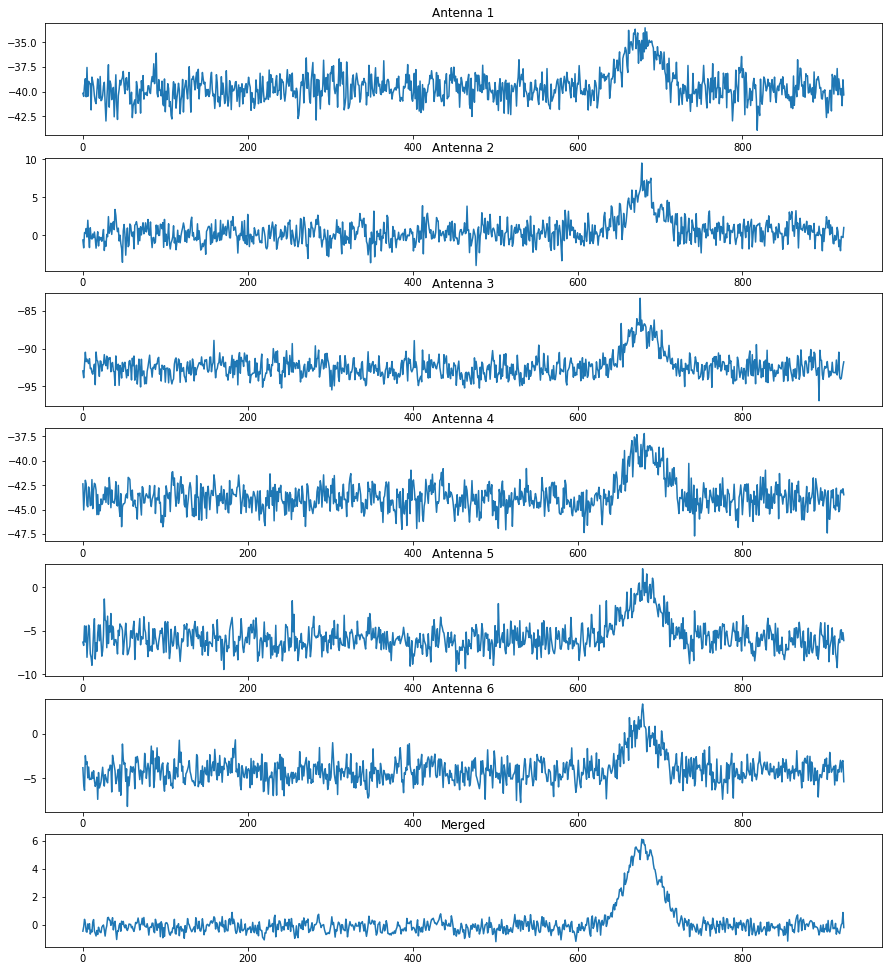

In [6]:
_, ax = plt.subplots(7, figsize=(15, 17))
# Plot the same spectrum from each antenna.
for i, f in enumerate(glob.glob("generated.ant?.hdf5")):
    t = Table.read(f, path="quotiented")
    ax[i].set_title("Antenna {0}".format(i+1))
    s = np.where(t["source"] == "m45_04003")[0][0]
    ax[i].plot(t["xx"][s])
# Plot the merged one.
t = Table.read("generated.merged.hdf5", path="data")
ax[-1].set_title("Merged")
s = np.where(t["source"] == "m45_04003")[0][0]
ax[-1].plot(t["spectrum"][s])

## Gridding

Finally, `brewmaster` can grid the data to produce a cube. Note that this functionality produces a similar result to `gridzilla`, but is approximately 100x faster.

In [7]:
g = Grid("generated.merged.hdf5",
         projection="galactic",       # (optional) J2000 or galactic.
         bunit="Jy",                  # (optional) The output units of the cube. 
         rest_freq=44.06941,          # (optional) The rest frequency of the spectral line within the data.
         path="data")                 # (default) The HDF5 path to read from.
g.setup_fits_header(pix_size=None,    # (optional) If None, let brewmaster determine pixel sizes from the pixel ratio.
                    pix_ratio=4.0,    # (default) Use this many pixels per beam.
                    map_padding=0.02) # (default) Pad the spatial extent of the cube by this many degrees.
# Refer to the cygrid paper for more details on these parameters: https://arxiv.org/abs/1604.06667
g.grid(kernel_type="gauss1d",
       kernel_size_sigma=0.4,
       kernel_support=3,
       hpx_maxres=0.5)
g.write(output_filename="generated.fits")

## Viewing results

This plot shows a slice of the cube produced by `brewmaster`, featuring a signal.

INFO: Auto-setting vmin to -1.270e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.694e+00 [aplpy.core]


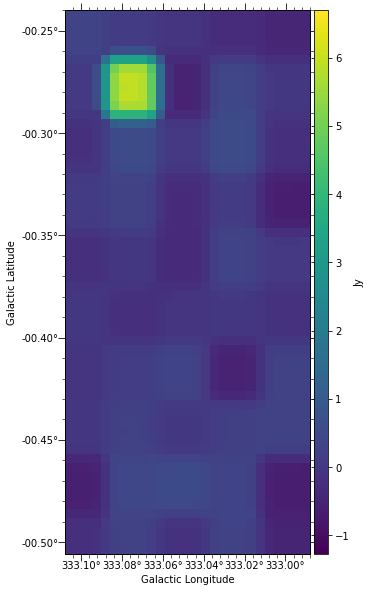

In [8]:
fig = plt.figure(figsize=(5, 10))
f = aplpy.FITSFigure("generated.fits", slices=[300], figure=fig)
f.tick_labels.set_xformat("ddd.dd")
f.tick_labels.set_yformat("ddd.dd")
f.ticks.set_color("black")
f.show_colorscale(cmap="viridis")
f.add_colorbar()
f.colorbar.set_axis_label_text("Jy")

The following shows the peak-intensity map of the generated data.

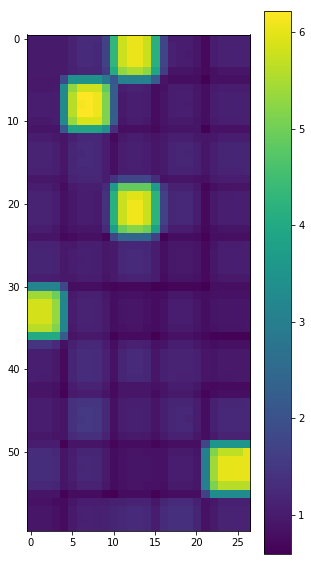

In [9]:
data = fits.getdata("generated.fits")
_, ax = plt.subplots(figsize=(5, 10))
image = ax.imshow(np.flipud(np.max(data, axis=0)))
plt.colorbar(image, ax=ax)

## Extension
For comparison, we can look at each antenna gridded individually.

In [10]:
scales = list(range(4, 20, 2)) + list(range(20, 40, 3)) + list(range(40, 100, 5))

for f in sorted(glob.glob("generated.ant?.hdf5")):
    basename, _ = os.path.splitext(f)
    merged = basename + ".merged.hdf5"

    m = Merge(f)
    m.find_common_sources()
    m.merge_spectra(scales)
    m.write(output_filename=merged)

    g = Grid(merged)
    g.setup_fits_header()
    g.grid()
    g.write(output_filename=basename + ".merged.fits")

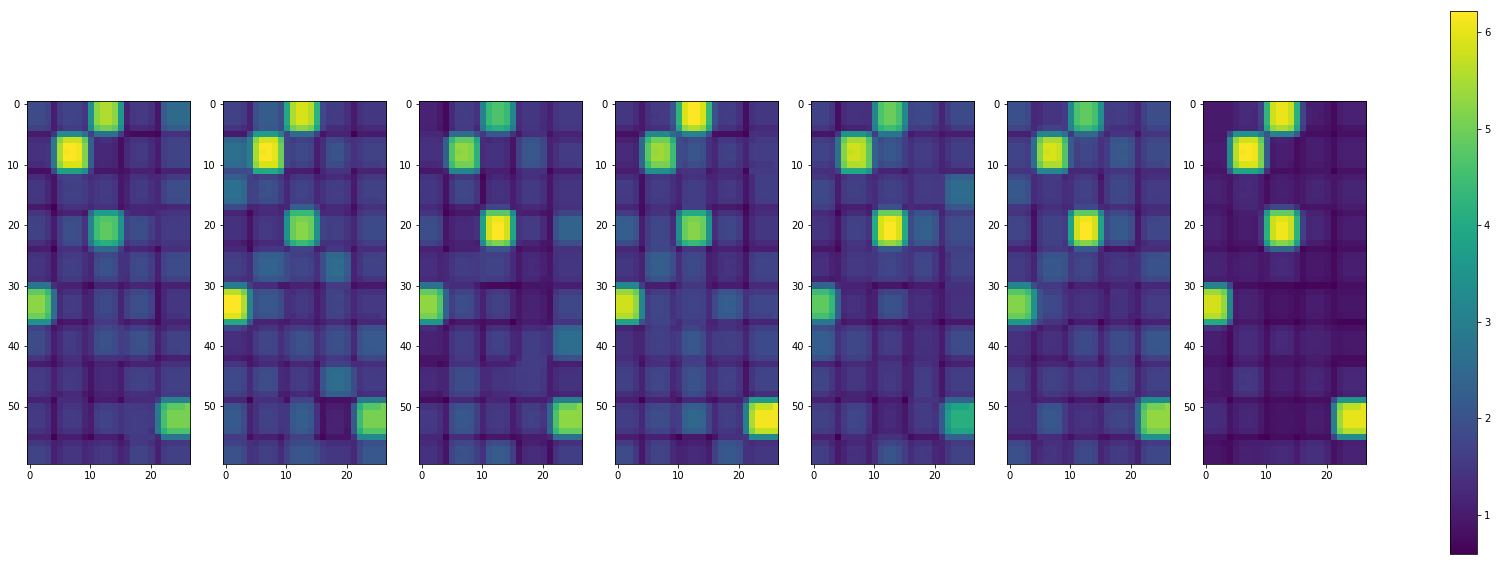

In [11]:
_, ax = plt.subplots(1, 7, figsize=(30, 10))

# Plot each antenna...
for j, i in enumerate(sorted(glob.glob("generated.ant*.fits"))):
    data = fits.getdata(i)
    image = ax[j].imshow(np.flipud(np.max(data, axis=0)))

# ... then the merged product calculated earlier.
data = fits.getdata("generated.fits")
image = ax[-1].imshow(np.flipud(np.max(data, axis=0)))
plt.colorbar(image, ax=ax)